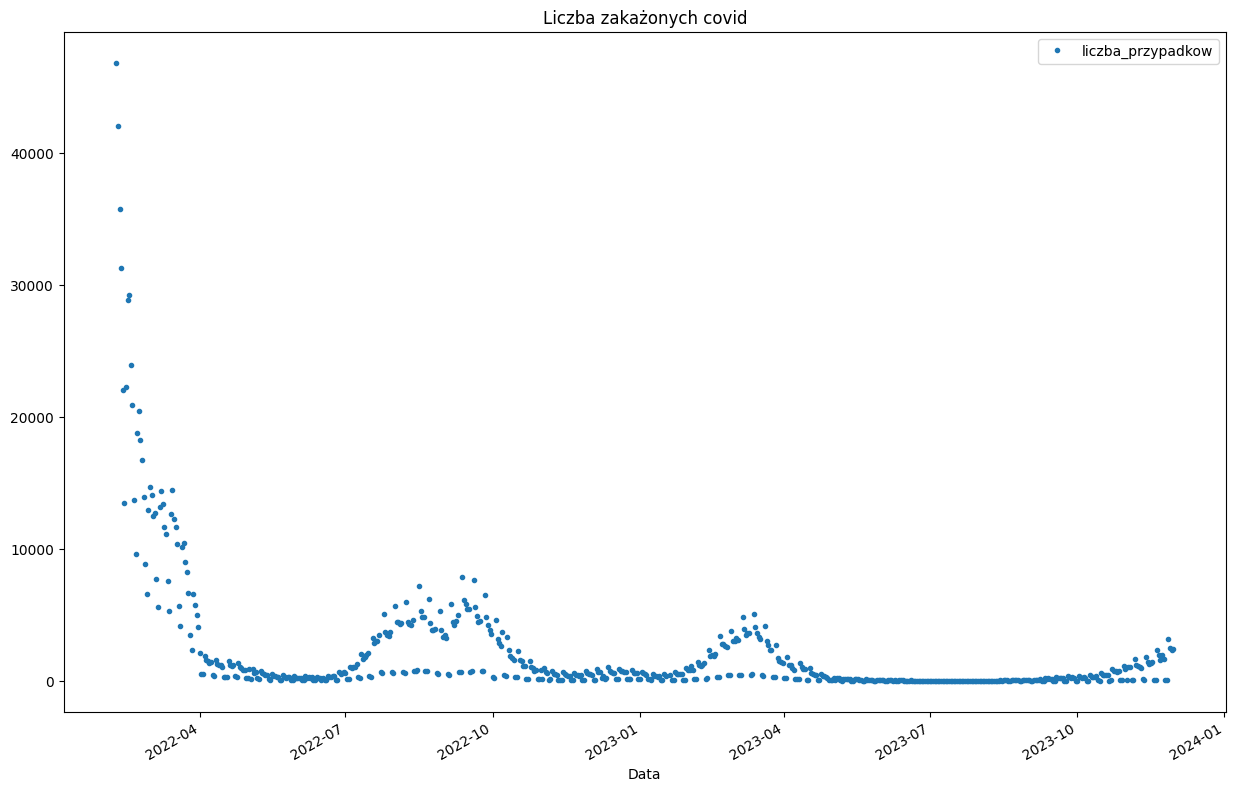

In [1]:
''' 
Prognoza: 45 747 zakażeń

Predcykcja zakażeń na covid w miesiącu grudzień 2023, 
model został zbudowany w oparciu o metody uczenia maszynowego
- bibliotekę xgboost, została przeprowadzona walidacja krzyżowa, 
w procesie konstrukcji skupiono się na minimalizacji RMSE.
Dane został uprzednio przetworzone, ich zakres został dobrany tak, 
aby model uzyskał moc predykyjną zbliżoną do rzeczywistych obserwacji.
Wyniki predykcji znajdują się na końcu kodu.

Projekt wykonano na poniższych wersjach bibliotek:
Pandas version: 2.1.1
Numpy version: 1.26.0
Matplotlib version: 3.8.0
Seaborn version: 0.13.0
XGBoost version: 2.0.2
'''

#importujemy potrzebne biblioteki oraz plik z danymi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


df = pd.read_csv('/Users/krzysztofkapusta/Downloads/danehistorycznewojewodztwa-2/DANE.csv', delimiter = ';')

df['liczba_przypadkow'] = pd.to_numeric(df['liczba_przypadkow'], errors='coerce')
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df.set_index('Data', inplace = True)
df.index = pd.to_datetime(df.index)

#wizualizacja danych

color_pal = sns.color_palette()

df.plot(style = '.', 
        figsize = (15,10), 
        color = color_pal[0], 
        title = 'Liczba zakażonych covid')
plt.show()

<Axes: ylabel='Frequency'>

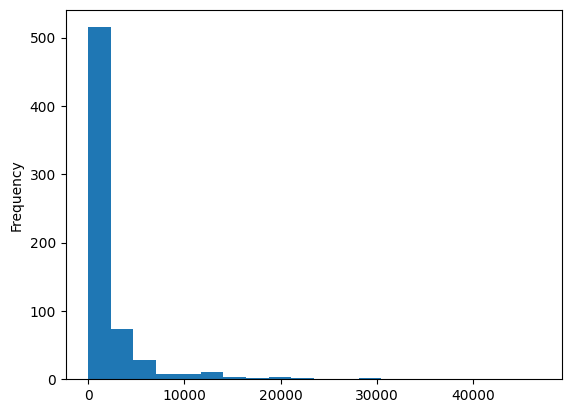

In [2]:
#histogram rozkładu obserwacji, potrzebny do późniejszego usunięcia obserwacji nietypowych

df['liczba_przypadkow'].plot(kind = 'hist', bins = 20)

<Axes: xlabel='Data'>

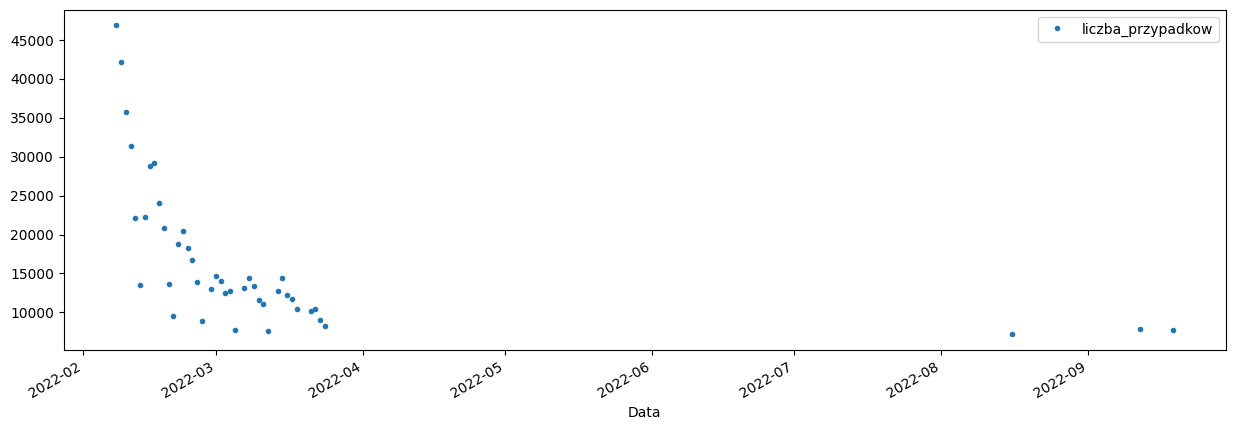

In [3]:
'''usunięcie obserwacji nietypowych, z uwagi na specyfikę problemu,
outlayery zostały usunięte w sposób uznaniowy, tak aby uzyskać lepszą moc predykcyjną'''

df.query('`liczba_przypadkow` > 7000').plot(figsize=(15, 5), style='.')

In [4]:
df = df.query('`liczba_przypadkow` < 7000').copy()

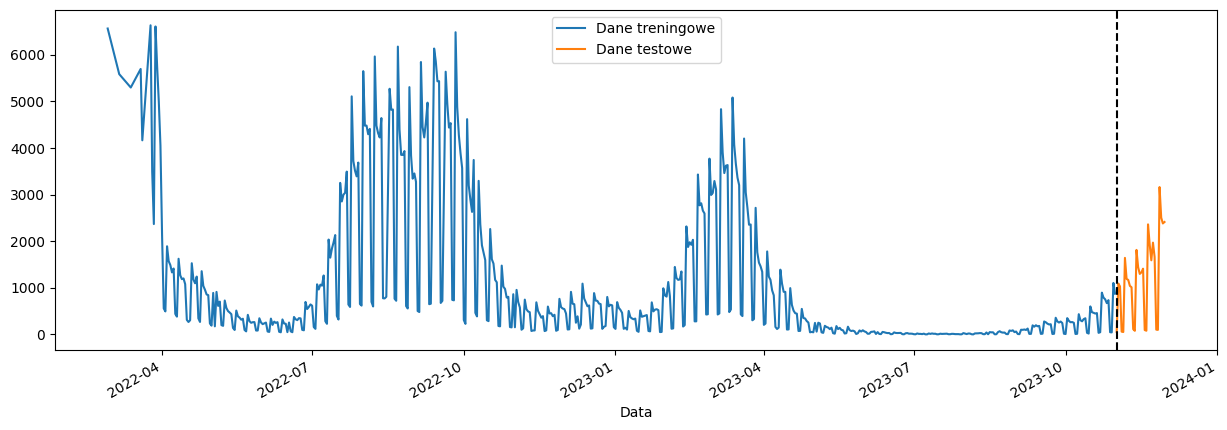

In [5]:
# Poniżej danee zostaną podzielone na zbiór testowy i treningowy, zostanie przeprowadzona walidacja krzyżowa

train = df.loc[df.index < '11-01-2023']
test = df.loc[df.index >= '11-01-2023']

fig, ax = plt.subplots(figsize= (15, 5))
train.plot(ax=ax, label = "trening")
test.plot(ax=ax, label = "test")
ax.axvline('11-01-2023', color = 'black', ls = '--')
ax.legend(['Dane treningowe', 'Dane testowe '])
plt.show()

In [6]:
tss = TimeSeriesSplit(n_splits = 18, test_size = 31, gap = 4)
df = df.sort_index()

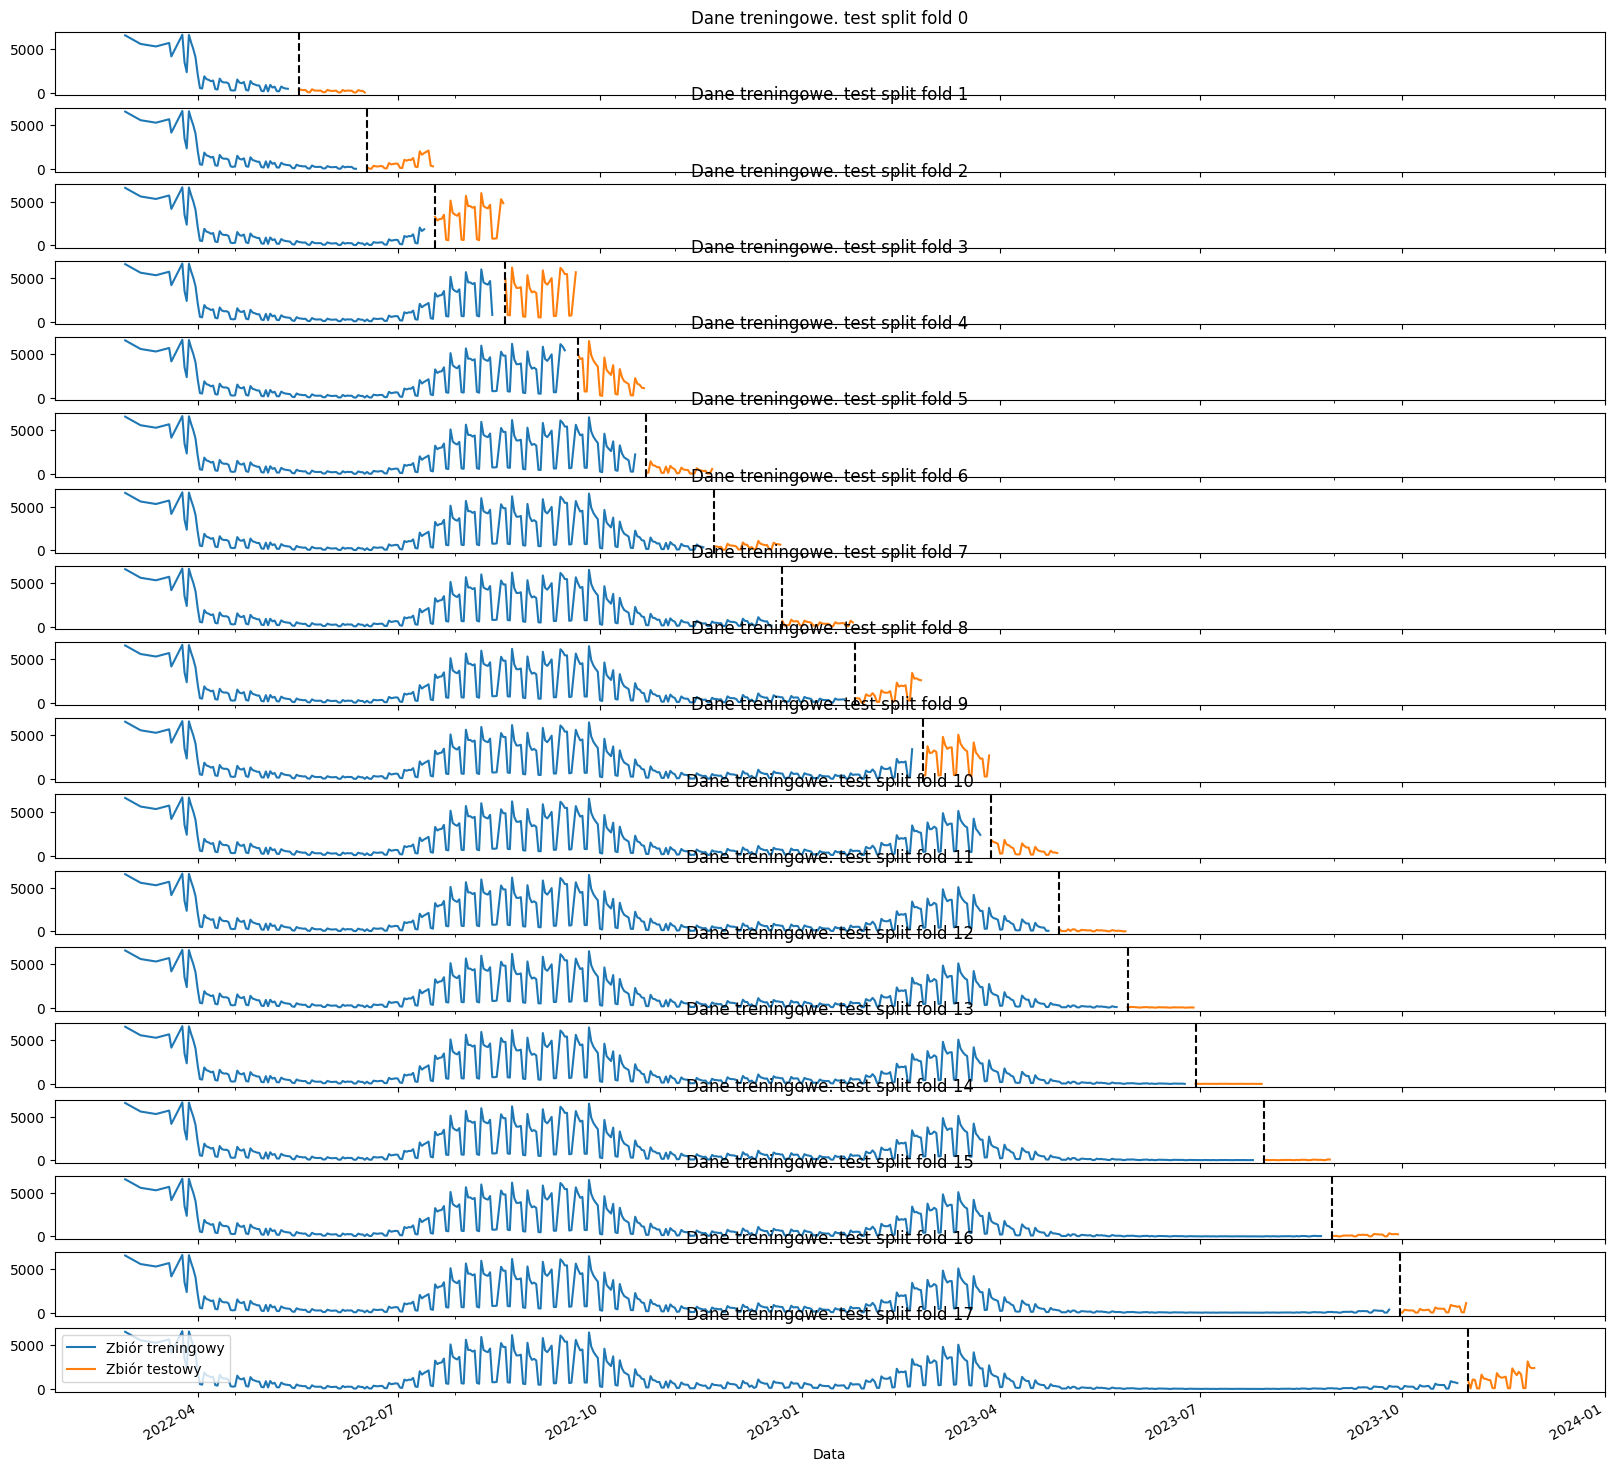

In [7]:
fig, axs = plt.subplots(18, 1, figsize=(20, 20), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]  
    test = df.iloc[val_idx]
    
    train['liczba_przypadkow'].plot(ax=axs[fold], label="Zbiór treningowy", title=f'Dane treningowe. test split fold {fold}')
    test['liczba_przypadkow'].plot(ax=axs[fold], label="Zbiór testowy")
    
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.legend()
plt.show()

In [8]:
#dodaje cechy zbioru potrzebne do predykcji 

def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year

    return df

df = create_features(df)

In [9]:
#dodaje opóźnienia potrzebne do predykcji 

target_map = df["liczba_przypadkow"].to_dict()

def add_lags(df):
    target_map = df['liczba_przypadkow'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('29 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('36 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('57 days')).map(target_map)
    return df

df = add_lags(df)

In [10]:
#trenuje model 

tss = TimeSeriesSplit(n_splits = 18, test_size = 31, gap = 4)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]  
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['dayofweek','quarter','month', 'year', 'dayofyear', 'lag1', 'lag2', 'lag3']
    TARGET = "liczba_przypadkow"
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    
    reg = xgb.XGBRegressor(base_score = 0.1, booster = 'gbtree',
                        n_estimators = 1000,
                        early_stopping_rounds = 40,
                        objective = 'reg:squarederror',
                        max_depth = 12,
                        learning_rate = 0.01,
                        random_state=22
                        )
    reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 200)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:2607.97982	validation_1-rmse:242.59276
[115]	validation_0-rmse:1056.56986	validation_1-rmse:93.09786
[0]	validation_0-rmse:2084.77022	validation_1-rmse:941.78757
[200]	validation_0-rmse:466.82277	validation_1-rmse:789.31635
[400]	validation_0-rmse:135.92701	validation_1-rmse:766.93415
[600]	validation_0-rmse:44.46254	validation_1-rmse:762.83526
[800]	validation_0-rmse:14.96899	validation_1-rmse:762.30577
[999]	validation_0-rmse:5.35030	validation_1-rmse:762.07251
[0]	validation_0-rmse:1829.44941	validation_1-rmse:3606.29847
[200]	validation_0-rmse:409.98674	validation_1-rmse:2460.88772
[400]	validation_0-rmse:119.57337	validation_1-rmse:2270.70910
[600]	validation_0-rmse:39.42931	validation_1-rmse:2223.46602
[800]	validation_0-rmse:13.36947	validation_1-rmse:2217.47557
[999]	validation_0-rmse:4.90556	validation_1-rmse:2216.08746
[0]	validation_0-rmse:2249.07829	validation_1-rmse:3931.19376
[200]	validation_0-rmse:465.51645	validation_1-rmse:1091.10979
[400]	valida

In [11]:
#ocena modelu
print(f'Scores across folds: {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')

Scores across folds: 556.3924
Fold scores: [66.85839225318001, 762.072497511838, 2216.0874371199675, 741.9506142131354, 1214.3675575544519, 255.45397049517726, 199.45276383709577, 308.52106571323753, 1242.6604788338952, 1602.0544411997907, 323.9252262670522, 44.00584296906045, 36.65796177018902, 9.655874679964331, 26.914007181150776, 136.98264729208128, 206.406899565025, 621.0351156682091]


In [12]:
#ponowne trenowanie

df = create_features(df)

FEATURES = ['dayofweek','quarter','month', 'year', 'dayofyear', 'lag1', 'lag2', 'lag3']
TARGET = "liczba_przypadkow"

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score = 0.1, booster = 'gbtree',
                        n_estimators = 1000,
                        early_stopping_rounds = 40,
                        objective = 'reg:squarederror',
                        max_depth = 12,
                        learning_rate = 0.01,
                        )
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 200)

[0]	validation_0-rmse:1824.52843	validation_1-rmse:1474.35566
[200]	validation_0-rmse:367.75212	validation_1-rmse:724.31829
[400]	validation_0-rmse:98.08989	validation_1-rmse:644.62809
[600]	validation_0-rmse:31.01499	validation_1-rmse:622.45533
[736]	validation_0-rmse:15.09930	validation_1-rmse:621.30898


XGBRegressor(base_score=0.1, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=40,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

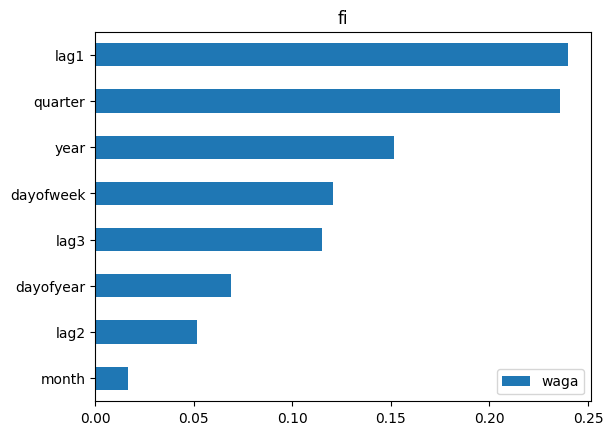

In [13]:
#wagi cech

fi = pd.DataFrame(data = reg.feature_importances_,
            index = reg.feature_names_in_,
            columns = ['waga'])
fi.sort_values('waga').plot(kind = 'barh', title = 'fi')
plt.show()

In [14]:
#Utworzenie df na prognozowany okres 
future = pd.date_range('2023-12-01', '2023-12-31')
future_df = pd.DataFrame(index = future)

future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [15]:
future_w_features = df_and_future.query('isFuture').copy()

<Axes: title={'center': 'Prognoza'}>

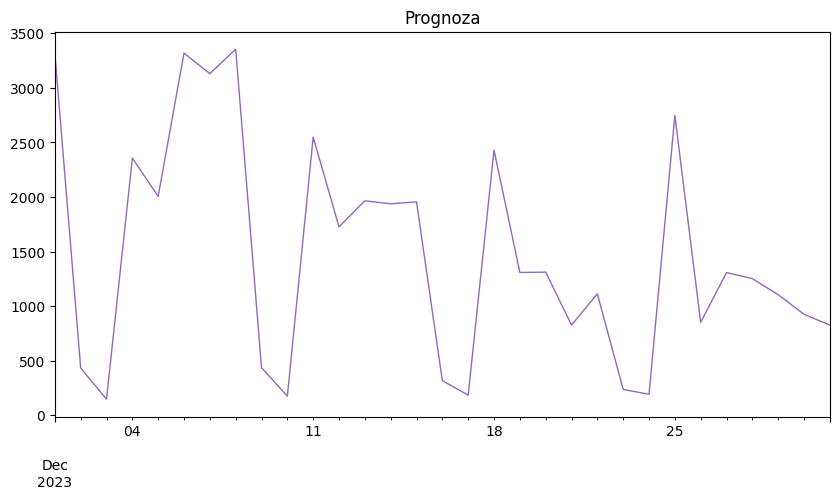

In [16]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize = (10,5), color = color_pal[4], ms =1, lw = 1, title = 'Prognoza')

In [17]:
future_w_features

,liczba_przypadkow,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,isFuture,pred
2023-12-01,NaN,4,4,12,2023,335,1091.0,671.0,265.0,True,3320.520508
2023-12-02,NaN,5,4,12,2023,336,1030.0,735.0,249.0,True,432.593842
2023-12-03,NaN,6,4,12,2023,337,59.0,47.0,9.0,True,147.715927
2023-12-04,NaN,0,4,12,2023,338,51.0,43.0,13.0,True,2356.160156
2023-12-05,NaN,1,4,12,2023,339,1642.0,1104.0,434.0,True,2006.143555
2023-12-06,NaN,2,4,12,2023,340,1191.0,874.0,304.0,True,3318.579590
2023-12-07,NaN,3,4,12,2023,341,1169.0,53.0,281.0,True,3129.956299
2023-12-08,NaN,4,4,12,2023,342,1041.0,1091.0,328.0,True,3354.343994
2023-12-09,NaN,5,4,12,2023,343,1012.0,1030.0,346.0,True,436.363068
2023-12-10,NaN,6,4,12,2023,344,113.0,59.0,34.0,True,174.799866


In [18]:
#Wynik prognozy: 45 747 zakażeń

print('Liczba zakażeń COVID w grudniu 2023:', (future_w_features['pred'].sum()).astype(int))

Liczba zakażeń COVID w grudniu 2023: 45747
